In [83]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from time import time

con = create_engine(os.environ['db_uri'], echo=False).raw_connection()

In [175]:
currency = "GBP"
sql = "select date,currency,rate \
       from dw.currency \
       where \
        currency = %(currency)s \
        and date between %(start)s and %(end)s \
       group by 1, 2, 3 \
       order by date"
df = pd.read_sql(sql,con,
                 params={'currency':currency,
                         'start':'2010-01-01',
                         'end':'2017-12-31'},index_col='date',parse_dates=['date'])
# mutliple_sql = "select date,currency,rate \
#        from dw.currency \
#        where \
#         date between %(start)s and %(end)s \
#        group by 1, 2, 3"
# df = pd.read_sql(mutliple_sql,con,
#                  params={'start':'2010-01-01',
#                          'end':'2017-12-31'},index_col='date',parse_dates=['date'])
df['date'] = df.index

In [176]:
df.head()

,currency,rate,date
date,,,
2016-07-07,GBP,1.294985,2016-07-07
2016-07-10,GBP,1.299528,2016-07-10
2016-07-11,GBP,1.325469,2016-07-11
2016-07-12,GBP,1.310960,2016-07-12
2016-07-13,GBP,1.334098,2016-07-13


In [177]:
df.describe()

,rate
count,200.000000
mean,1.263149
std,0.036644
min,1.203862
25%,1.236029
50%,1.249391
75%,1.300301
max,1.342480


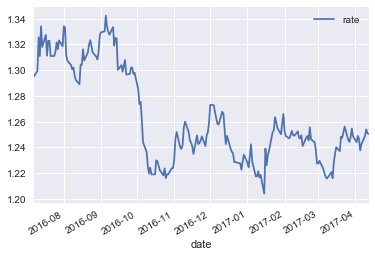

In [178]:
df.plot('date','rate')

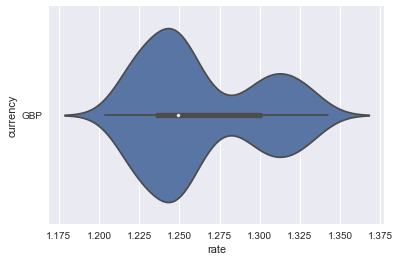

In [179]:
sns.violinplot(x='rate',y='currency',data=df)

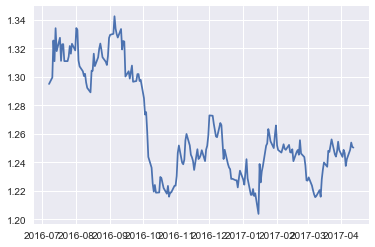

In [180]:
ts = df.rate
plt.plot(ts)

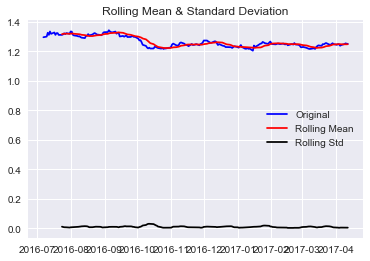

Results of Dickey-Fuller Test:
Test Statistic                  -1.689629
p-value                          0.436464
#Lags Used                       0.000000
Number of Observations Used    199.000000
Critical Value (1%)             -3.463645
Critical Value (5%)             -2.876176
Critical Value (10%)            -2.574572
dtype: float64


In [181]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts)

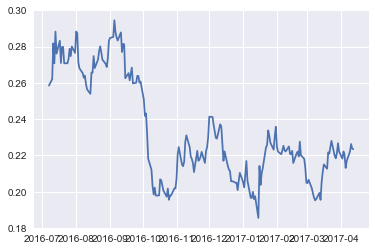

In [183]:
ts_log = np.log(ts)
plt.plot(ts_log)

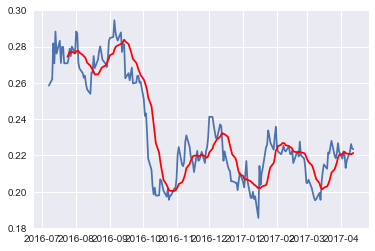

In [184]:
moving_avg = ts_log.rolling(window=12,center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

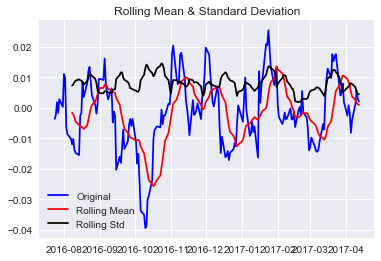

Results of Dickey-Fuller Test:
Test Statistic                  -3.607832
p-value                          0.005613
#Lags Used                       0.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [185]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

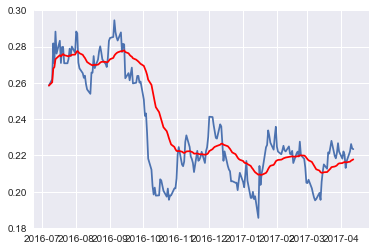

In [186]:
expwieghted_avg = ts_log.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_log)
plt.plot(expwieghted_avg, color='red')

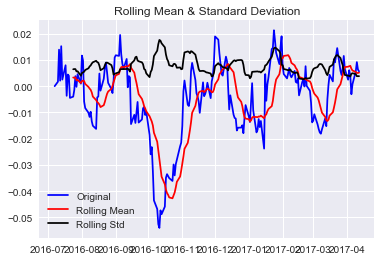

Results of Dickey-Fuller Test:
Test Statistic                  -2.958520
p-value                          0.038954
#Lags Used                       0.000000
Number of Observations Used    199.000000
Critical Value (1%)             -3.463645
Critical Value (5%)             -2.876176
Critical Value (10%)            -2.574572
dtype: float64


In [187]:
ts_log_ewma_diff = ts_log - expwieghted_avg
test_stationarity(ts_log_ewma_diff)

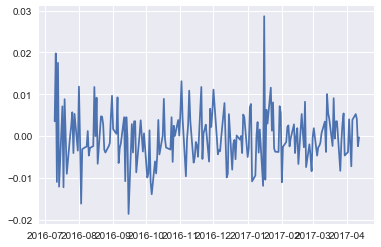

In [188]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

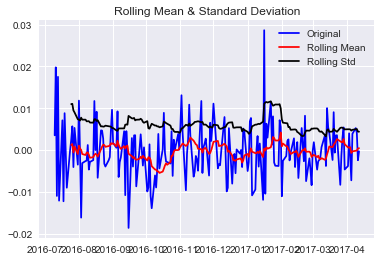

Results of Dickey-Fuller Test:
Test Statistic                -1.648641e+01
p-value                        2.212842e-29
#Lags Used                     0.000000e+00
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


In [189]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

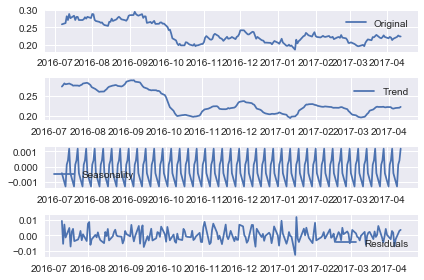

In [190]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

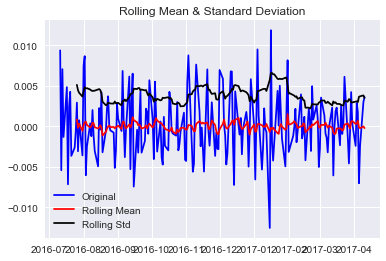

Results of Dickey-Fuller Test:
Test Statistic                -6.870867e+00
p-value                        1.516893e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.830000e+02
Critical Value (1%)           -3.466598e+00
Critical Value (5%)           -2.877467e+00
Critical Value (10%)          -2.575260e+00
dtype: float64


In [191]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

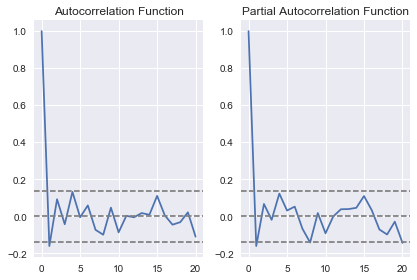

In [192]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

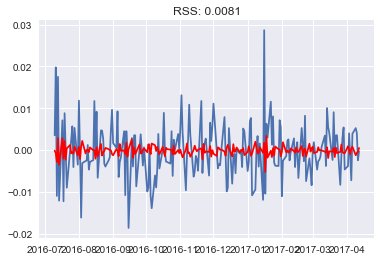

In [193]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

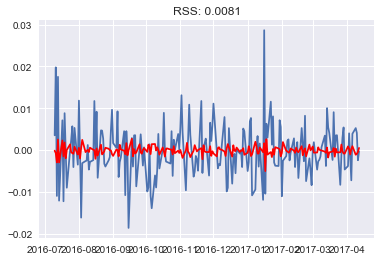

In [194]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

/Users/skilbjo/.virtualenvs/ts/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


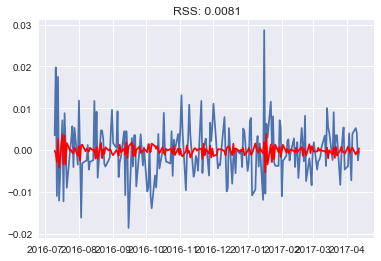

In [195]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [196]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2016-07-10   -0.000197
2016-07-11   -0.000795
2016-07-12   -0.002887
2016-07-13    0.002587
2016-07-14   -0.004270
dtype: float64

In [197]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2016-07-10   -0.000197
2016-07-11   -0.000992
2016-07-12   -0.003879
2016-07-13   -0.001291
2016-07-14   -0.005561
dtype: float64

In [198]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2016-07-07    0.258499
2016-07-10    0.258302
2016-07-11    0.257507
2016-07-12    0.254620
2016-07-13    0.257208
dtype: float64

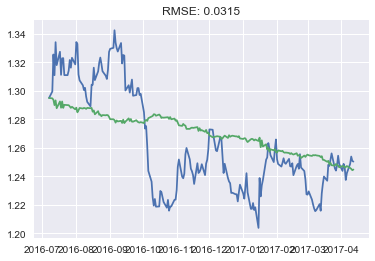

In [199]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))